# Custom Image Generator
This notebook creates a subclass of the Keras ImageGenerator that enables the facial keypoint images and corresponding labels to be

* flipped horizontally
* zoomed
* translated
* rotated

This enables us to enhance the training data set.

The Keras ImageGenerator allowed image transformations, but did not implement any corresponding changes to labels. Therefore, we subclass the ImageGenerator and edit methods where necessary to update the labels in addition to the images.

### Imports

In [2]:
%matplotlib inline
from pandas.io.parsers import read_csv
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import NumpyArrayIterator
import scipy.ndimage as ndi


Using TensorFlow backend.


### Constants

In [3]:
TRAIN_DATA = '../../data/training.csv'
TEST_DATA = '../../data/test.csv'
IMAGE_ROWS = 96
IMAGE_COLS = 96
INPUT_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)

### Load the data

In [4]:
def loader(test=False, seed=None, keeplabels=None):
    if seed:
        np.random.seed(seed)
    fileloc = TEST_DATA if test else TRAIN_DATA
    
    df = read_csv(fileloc)
    
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    
    if keeplabels:
        df = df[list(keeplabels) + ['Image']]
        
    df = df.dropna() # drop rows with missing labels
    
    X = np.vstack(df['Image'])
    # by pixel across the whole dataset subtract mean and divide by stdev
    X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
    X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns.difference(['Image'])].values
        y = y.astype(np.float32)
        y = (y - 48) / 48 # this helps, but tanh on output doesnt
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
    else:
        y = None
    
    X = X.reshape(-1, IMAGE_ROWS, IMAGE_COLS, 1)

    return X, y, df.columns.difference(['Image'])


In [5]:
X, y, labels = loader(seed=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)

### Plot some examples using the Keras Generator

In [6]:
def plot_image(image, points, labels=list(labels)):
    """Helper function to plot images"""
    plt.figure(figsize=(4,4))
    plt.imshow(np.reshape(image,(96,96)), cmap = 'gray')
    x = 0
    for i, label in enumerate(labels):
        if label[-1]=='x':
            x = points[i]
        else:
            if label in ['left_eye_center_y',
                         'left_eye_inner_corner_y', 
                         'left_eye_outer_corner_y', 
                         'left_eyebrow_inner_end_y', 
                         'left_eyebrow_outer_end_y',
                         'mouth_left_corner_y'
                        ]:
                plt.plot(x, points[i], 'b<')
            elif label in ['right_eye_center_y',
                         'right_eye_inner_corner_y', 
                         'right_eye_outer_corner_y', 
                         'right_eyebrow_inner_end_y', 
                         'right_eyebrow_outer_end_y',
                          'mouth_right_corner_y']:
                plt.plot(x, points[i], 'r>')
            else:
                plt.plot(x, points[i],'g.')
    plt.axis('off')

(30,)


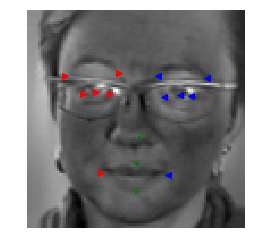

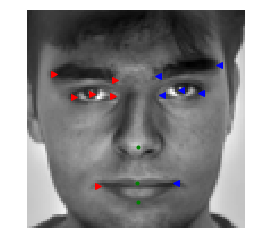

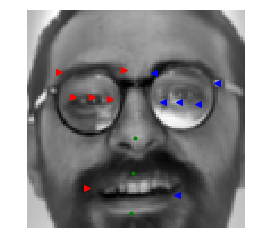

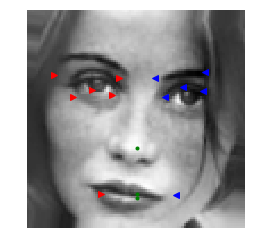

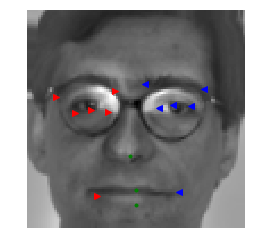

In [7]:
datagen = ImageDataGenerator(
    rotation_range=10.,
    horizontal_flip=True)
batch = 5
ex_trans = datagen.flow(X_train,y_train, batch_size=batch).next()
print(ex_trans[1][0].shape)
for i in range(batch):
    plot_image(ex_trans[0][i],ex_trans[1][i]*48+48)
    

Note that the labels no longer match the images after the images have been transformed

### Subclass the Keras ImageGenerator to update the labels

In [8]:
def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix


def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.):
    """Apply the image transformation specified by a matrix.
    # Arguments
        x: 2D numpy array, single image.
        transform_matrix: Numpy array specifying the geometric transformation.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        The transformed version of the input.
    """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=1,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

class CustImageDataGenerator(ImageDataGenerator):
    """Custom Image Generator
    Extends the Keras Image Data Generator
    But also allows y to change in addition to x upon transformation
    """
    def flow(self, x, y=None, whichlabels=None, batch_size=32,
             shuffle=True, seed=None,save_to_dir=None,
             save_prefix='', save_format='png', subset=None):
        return CustNumpyArrayIterator(
            x, y, whichlabels, self,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            subset=subset
        )
    
    def random_transform(self, x, y, whichlabels, seed=None):
        """Randomly augment a single image tensor.
        # Arguments
            x: 3D tensor, single image.
            seed: random seed.
        # Returns
            A randomly transformed version of the input (same shape) and the output.
            
            This is the key change vs the old Keras implementation
        """
        # x is a single image, so it doesn't have image number at index 0
        img_row_axis = self.row_axis - 1
        img_col_axis = self.col_axis - 1
        img_channel_axis = self.channel_axis - 1

        if seed is not None:
            np.random.seed(seed)
            
        # flip with 1/2 prob
        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_col_axis)
                # make a dict with the y values
                y_dict = dict(zip(whichlabels,list(y)))
                
                # flip x coordinates and left with right labels
                for ii, label in enumerate(whichlabels):
                    if label == 'left_eye_center_x':
                        y[ii] = -1*y_dict['right_eye_center_x']
                    if label == 'left_eye_center_y':
                        y[ii] = y_dict['right_eye_center_y']
                    if label == 'left_eye_inner_corner_x':
                        y[ii] = -1*y_dict['right_eye_inner_corner_x']
                    if label == 'left_eye_inner_corner_y':
                        y[ii] = y_dict['right_eye_inner_corner_y']
                    if label == 'left_eye_outer_corner_x':
                        y[ii] = -1*y_dict['right_eye_outer_corner_x']
                    if label == 'left_eye_outer_corner_y':
                        y[ii] = y_dict['right_eye_outer_corner_y']
                    if label == 'left_eyebrow_inner_end_x':
                        y[ii] = -1*y_dict['right_eyebrow_inner_end_x']
                    if label == 'left_eyebrow_inner_end_y':
                        y[ii] = y_dict['right_eyebrow_inner_end_y']
                    if label == 'left_eyebrow_outer_end_x':
                        y[ii] = -1*y_dict['right_eyebrow_outer_end_x']
                    if label == 'left_eyebrow_outer_end_y':
                        y[ii] = y_dict['right_eyebrow_outer_end_y']
                    if label == 'mouth_center_bottom_lip_x':
                        y[ii] = -1*y_dict['mouth_center_bottom_lip_x']
#                     if label == 'mouth_center_bottom_lip_y':
#                         y[ii] = y_dict['']
                    if label == 'mouth_center_top_lip_x':
                        y[ii] = -1*y_dict['mouth_center_top_lip_x']
#                     if label == 'mouth_center_top_lip_y':
#                         y[ii] = y_dict['']
                    if label == 'mouth_left_corner_x':
                        y[ii] = -1*y_dict['mouth_right_corner_x']
                    if label == 'mouth_left_corner_y':
                        y[ii] = y_dict['mouth_right_corner_y']
                    if label == 'mouth_right_corner_x':
                        y[ii] = -1*y_dict['mouth_left_corner_x']
                    if label == 'mouth_right_corner_y':
                        y[ii] = y_dict['mouth_left_corner_y']
                    if label == 'nose_tip_x':
                        y[ii] = -1*y_dict['nose_tip_x']
#                     if label == 'nose_tip_y':
#                         y[ii] = y_dict['']
                    if label == 'right_eye_center_x':
                        y[ii] = -1*y_dict['left_eye_center_x']
                    if label == 'right_eye_center_y':
                        y[ii] = y_dict['left_eye_center_y']
                    if label == 'right_eye_inner_corner_x':
                        y[ii] = -1*y_dict['left_eye_inner_corner_x']
                    if label == 'right_eye_inner_corner_y':
                        y[ii] = y_dict['left_eye_inner_corner_y']
                    if label == 'right_eye_outer_corner_x':
                        y[ii] = -1*y_dict['left_eye_outer_corner_x']
                    if label == 'right_eye_outer_corner_y':
                        y[ii] = y_dict['left_eye_outer_corner_y']
                    if label == 'right_eyebrow_inner_end_x':
                        y[ii] = -1*y_dict['left_eyebrow_inner_end_x']
                    if label == 'right_eyebrow_inner_end_y':
                        y[ii] = y_dict['left_eyebrow_inner_end_y']
                    if label == 'right_eyebrow_outer_end_x':
                        y[ii] = -1*y_dict['left_eyebrow_outer_end_x']
                    if label == 'right_eyebrow_outer_end_y':
                        y[ii] = y_dict['left_eyebrow_outer_end_y']        
        
        
        
        # use composition of homographies
        # to generate final transform that needs to be applied
        
        ## first get random amounts of transformation
        # rotation
        if self.rotation_range:
            theta = np.deg2rad(np.random.uniform(-self.rotation_range, self.rotation_range))
        else:
            theta = 0
                    
        # translation
        if self.height_shift_range:
            tx = np.random.uniform(-self.height_shift_range, self.height_shift_range)
            if self.height_shift_range < 1:
                tx *= x.shape[img_row_axis]
        else:
            tx = 0

        if self.width_shift_range:
            ty = np.random.uniform(-self.width_shift_range, self.width_shift_range)
            if self.width_shift_range < 1:
                ty *= x.shape[img_col_axis]
        else:
            ty = 0
        
        # zoom
        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            z = 1
        else:
            z = np.random.uniform(self.zoom_range[0], self.zoom_range[1], 1)
            
        
        # build the matrix that will shift the image input data
        transform_matrix = None
        if theta != 0:
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                        [np.sin(theta), np.cos(theta), 0],
                                        [0, 0, 1]])
            transform_matrix = rotation_matrix
        
        if tx != 0 or ty != 0:
            shift_matrix = np.array([[1, 0, tx],
                                     [0, 1, ty],
                                     [0, 0, 1]])
            transform_matrix = shift_matrix if transform_matrix is None else np.dot(shift_matrix, transform_matrix)
        
        if z != 1:
            zoom_matrix = np.array([[z, 0, 0],
                                    [0, z, 0],
                                    [0, 0, 1]])
            transform_matrix = zoom_matrix if transform_matrix is None else np.dot(zoom_matrix, transform_matrix)
        
        # potentially apply the matrix transformation
        if transform_matrix is not None:
            # find the new location of the keypoints based on the changes
            # make a dict with the y values
            y_dict = dict(zip(whichlabels,list(y)))
            
            y_temp = np.copy(y)
            
            # change the coordinates of the labels
            # rotate
            for ii, label in enumerate(whichlabels):
                if label[-1]=='x':
                    y_temp[ii] = y_dict[label[:-1]+'y']*np.sin(-theta) + y_dict[label]*np.cos(-theta)
                elif label[-1]=='y':
                    y_temp[ii] = y_dict[label]*np.cos(-theta) - y_dict[label[:-1]+'x']*np.sin(-theta)
            # translate and zoom
            for ii, label in enumerate(whichlabels):
                if label[-1]=='x':
                    y_temp[ii] = z*(y_temp[ii] + (tx*2))
                elif label[-1]=='y':
                    y_temp[ii] = z*(y_temp[ii] - (ty*2))           
            
            # only apply the shifts if y is still in the image
            if np.max(y_temp)<=1 and np.min(y_temp)>=-1:
                y = y_temp
                h, w = x.shape[img_row_axis], x.shape[img_col_axis]
                transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
                x = apply_transform(x, transform_matrix, img_channel_axis,
                                fill_mode=self.fill_mode, cval=self.cval)
            
                
            
                    
        return x, y

class CustNumpyArrayIterator(NumpyArrayIterator):
    def __init__(self, x, y, whichlabels, image_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='png',
                 subset=None):
        if y is not None and len(x) != len(y):
            raise ValueError('`x` (images tensor) and `y` (labels) '
                             'should have the same length. '
                             'Found: x.shape = %s, y.shape = %s' %
                             (np.asarray(x).shape, np.asarray(y).shape))
        if subset is not None:
            if subset not in {'training', 'validation'}:
                raise ValueError('Invalid subset name:', subset,
                                 '; expected "training" or "validation".')
            split_idx = int(len(x) * image_data_generator._validation_split)
            if subset == 'validation':
                x = x[:split_idx]
                if y is not None:
                    y = y[:split_idx]
            else:
                x = x[split_idx:]
                if y is not None:
                    y = y[split_idx:]
        if data_format is None:
            data_format = K.image_data_format()
        self.x = np.asarray(x, dtype='float32')
        if self.x.ndim != 4:
            raise ValueError('Input data in `NumpyArrayIterator` '
                             'should have rank 4. You passed an array '
                             'with shape', self.x.shape)
        channels_axis = 3 if data_format == 'channels_last' else 1
        if self.x.shape[channels_axis] not in {1, 3, 4}:
            warnings.warn('NumpyArrayIterator is set to use the '
                          'data format convention "' + data_format + '" '
                          '(channels on axis ' + str(channels_axis) + '), i.e. expected '
                          'either 1, 3 or 4 channels on axis ' + str(channels_axis) + '. '
                          'However, it was passed an array with shape ' + str(self.x.shape) +
                          ' (' + str(self.x.shape[channels_axis]) + ' channels).')
        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.image_data_generator = image_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        self.whichlabels = whichlabels
        super(NumpyArrayIterator, self).__init__(x.shape[0], batch_size, shuffle, seed)
    
    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros(tuple([len(index_array)] + list(self.x.shape)[1:]),
                           dtype='float32')
        batch_y = np.zeros(tuple([len(index_array)] + list(self.y.shape)[1:]),
                           dtype='float32')
        for i, j in enumerate(index_array):
            x = self.x[j]
            y = self.y[j]
            x, y = self.image_data_generator.random_transform(x.astype('float32'),
                                                          y.astype('float32'),
                                                             self.whichlabels)
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
            batch_y[i] = y
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=j,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
                
        return batch_x, batch_y
        
        

### Test the implemented subclass

(30,)


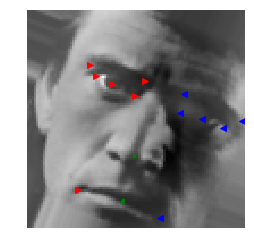

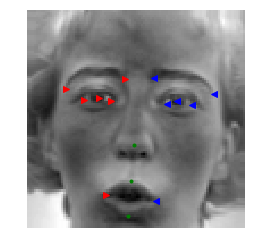

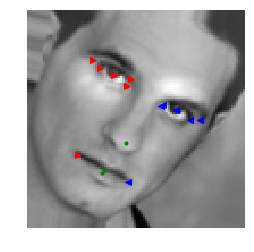

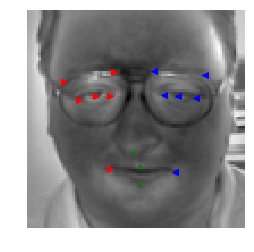

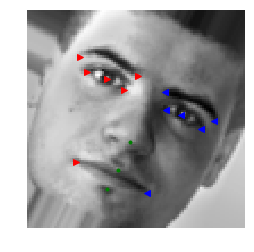

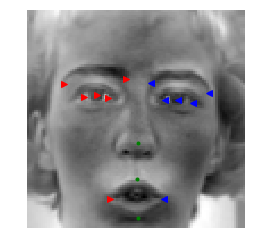

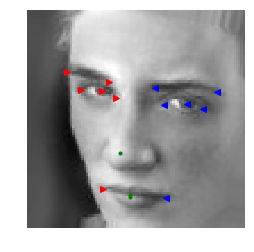

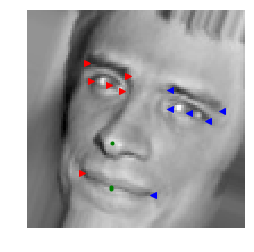

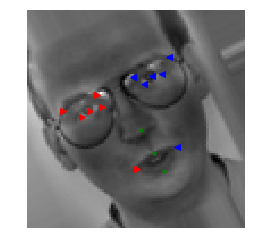

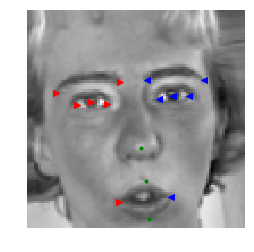

In [14]:
datagen = CustImageDataGenerator(
    rotation_range=30.,
    horizontal_flip=True,
    width_shift_range=.0,
    height_shift_range=.0
    )
batch = 10
ex_trans = datagen.flow(X_train,y_train,whichlabels=list(labels), batch_size=batch).next()
print(ex_trans[1][0].shape)
for i in range(batch):
    plot_image(ex_trans[0][i],ex_trans[1][i]*48+48)



Now the transformed images have labels that match!